In [8]:
!pip install keras_metrics owlready2 fasttext

from google.colab import drive
drive.mount("/content/drive")

import sys
sys.path.insert(0, '/content/drive/My Drive/Colab Notebooks')
import dataset_utils_2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Création fichier paires négatives


In [9]:
def nettoyer_unicode(c):
    liste_codes =  {
        'Ã\xa0': 'à',
        'Ã€': 'À',
        'Ã¢': 'â',
        'ã': 'â',
        'Ã‚': 'Â',
        'Ã©': 'é',
        'Ã©': 'é',
        'ã‰': 'é',
        'ãƒâ©': 'é',
        'Ã\x89': 'É',
        'Ã\xa8': 'è',
        'Ã\xaa': 'ê',
        'Ã\x8a': 'Ê', 
        'Ã¨': 'ê',       
        'Ã«': 'ë',
        'Ã®':'î',
        'Ã\x8e':'Î',        
        'Ã¯': 'ï', 
        'Ã´': 'ô',
        'Ã\x94': 'Ô',
        'Ã¹': 'ù', 
        'Ã»': 'û',
        'Å\x93': 'œ', 
        'Â«': '«',
        'Â»': '»',
        'Ã§': 'ç',
        'Ã\x87': 'Ç',
        'Âº': 'º',
        'â€™': '’',
        'â\x80\x99': '’',
        'â\x80\xa6' : '…',
    }
    
    for code in liste_codes:
        c = c.replace(code,liste_codes[code])
    return c

In [10]:
import csv 
import numpy as np

paires_diff = []
with open("/content/drive/My Drive/Colab Notebooks/neg_results.csv", encoding='UTF-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
      titre1_clean = nettoyer_unicode(row['title_raw1'])
      titre2_clean = nettoyer_unicode(row['title_raw2'])
      if (titre1_clean != titre2_clean): 
          paires_diff.append([titre1_clean, titre2_clean])
    print(len(paires_diff))
    np.save("paires_neg", paires_diff)        
    print(paires_diff)

4230
[['Les filles de joie', 'Les Filles de Caleb'], ['La guerre, yes sir', 'La guerre des épis'], ['Le livre des nombres', 'Le livre des momies'], ['Repères du silence', 'Rivages du silence'], ['Zazou', 'Cazou'], ['Le libraire', 'La librairie'], ['Annabelle', 'Annabel Lee'], ['La dernière escale', 'La dernière scène'], ['Poèmes II', 'Poémes [sic]'], ['La montagne secrète', 'La montagne sacrée'], ['Les patins', ' Les ravins '], ['Les patins', 'Les ravins'], ['La petite bergère', 'La petite écuyère'], ['Ã\x80 fleur de peau', 'La fleur de peau'], ['Amours délices et orgues', 'Amour, délice et orgie'], ["La vengeance d'un père", 'La vengeance de la mer'], ['Le bateau fantôme /', 'Le bateau fantôme'], ['Le bateau fantôme /', 'Le Drapeau fantôme'], ['Le néant quotidien', 'Le Pain quotidien'], ['Perles de silence', 'Eclats de silence'], ['La chasse aux monstres', 'La chasse aux autres'], ['Le Cadeau', 'Le cadeau'], ['La voix du silence', 'Voix du silence'], ['La vengeance du vampire', 'La ve

In [11]:
import numpy as np

#Paires positives
paires_pos = np.load("/content/drive/My Drive/Colab Notebooks/paires_pos.npy", allow_pickle = True)

#Paires negatives
paires_neg = np.load("/content/drive/My Drive/Colab Notebooks/paires_neg.npy", allow_pickle = True)

print(len(paires_pos), "paires positives")
print(len(paires_neg), "paires negatives")

#training
rand_pos_indices = np.random.choice(paires_pos.shape[0], 3500, replace=False)
training_data_pos = paires_pos[rand_pos_indices]
rand_neg_indices = np.random.choice(paires_neg.shape[0], 3500, replace=False)
training_data_neg = paires_neg[rand_neg_indices]

#training data
# formatter en X et Y pour CNN
id = []
titre1 = []
titre2 = []
for pair in training_data_neg:
  id.append(0)
  titre1.append(pair[0])
  titre2.append(pair[1])
for pair in training_data_pos:
  id.append(1)
  titre1.append(pair[0])
  titre2.append(pair[1])
train_data = [titre1, titre2, id]

#test
#get remaining pairs
remaining_pos_indices = np.array([x for x in np.arange(paires_pos.shape[0]) if not np.isin(x, rand_pos_indices)])
remaining_neg_indices = np.array([x for x in np.arange(paires_neg.shape[0]) if not np.isin(x, rand_neg_indices)])
remaining_pos = paires_pos[remaining_pos_indices]
remaining_neg = paires_neg[remaining_neg_indices]

#sélection aléatoire 500 paires positives et négatives
test_indices_pos = np.random.choice(remaining_pos.shape[0], 500, replace=False)
test_data_pos = remaining_pos[test_indices_pos]
test_indices_neg = np.random.choice(remaining_neg.shape[0], 500, replace=False)
test_data_neg = remaining_neg[test_indices_neg]

id = []
titre1 = []
titre2 = []
for pair in test_data_neg:
  id.append(0)
  titre1.append(nettoyer_unicode(pair[0]))
  titre2.append(nettoyer_unicode(pair[1]))
for pair in test_data_pos:
  id.append(1)
  titre1.append(nettoyer_unicode(pair[0]))
  titre2.append(nettoyer_unicode(pair[1]))
test_data = [titre1, titre2, id]

#validation
#get remaining pairs
remaining_pos_indices = np.array([x for x in np.arange(paires_pos.shape[0]) if not np.isin(x, remaining_pos_indices)])
remaining_neg_indices = np.array([x for x in np.arange(paires_neg.shape[0]) if not np.isin(x, remaining_neg_indices)])
remaining_pos = paires_pos[remaining_pos_indices]
remaining_neg = paires_neg[remaining_neg_indices]

#sélection aléatoire 500 paires positives et négatives
validation_indices_pos = np.random.choice(remaining_pos.shape[0], 250, replace=False)
valid_data_pos = remaining_pos[validation_indices_pos]
validation_indices_neg = np.random.choice(remaining_neg.shape[0], 250, replace=False)
valid_data_neg = remaining_neg[validation_indices_pos]

id = []
titre1 = []
titre2 = []
for pair in valid_data_neg:
  id.append(0)
  titre1.append(nettoyer_unicode(pair[0]))
  titre2.append(nettoyer_unicode(pair[1]))
for pair in valid_data_pos:
  id.append(1)
  titre1.append(nettoyer_unicode(pair[0]))
  titre2.append(nettoyer_unicode(pair[1]))
valid_data = [titre1, titre2, id]

8950 paires positives
4232 paires negatives


Récupérer FastText

On réalise la tokenisation du texte

In [12]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(lower=True, filters=',"!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'', char_level=True)
tokenizer.fit_on_texts(train_data[0] + train_data[1])

len_seq = 15

#afficher nombre de titres avec mots extra

train_data[0] = pad_sequences(tokenizer.texts_to_sequences(train_data[0]), maxlen=len_seq)
train_data[1] = pad_sequences(tokenizer.texts_to_sequences(train_data[1]), maxlen=len_seq)

#concatenate word vectors
conc = []
for index, val in enumerate(train_data[0]):
  conc.append(np.concatenate([train_data[0][index], train_data[1][index]]))
train_data.append(conc)

test_data[0] = pad_sequences(tokenizer.texts_to_sequences(test_data[0]), maxlen=len_seq)
test_data[1] = pad_sequences(tokenizer.texts_to_sequences(test_data[1]), maxlen=len_seq)

#concatenate word vectors
conc = []
for index, val in enumerate(test_data[0]):
  conc.append(np.concatenate([test_data[0][index], test_data[1][index]]))
test_data.append(conc)

valid_data[0] = pad_sequences(tokenizer.texts_to_sequences(valid_data[0]), maxlen=len_seq)
valid_data[1] = pad_sequences(tokenizer.texts_to_sequences(valid_data[1]), maxlen=len_seq)

#concatenate word vectors
conc = []
for index, val in enumerate(valid_data[0]):
  conc.append(np.concatenate([valid_data[0][index], valid_data[1][index]]))
valid_data.append(conc)


On va maintenant utiliser Fasttext pour définir les embeddings

In [13]:
import io
import os

# si il n'existe pas déjà une matrice de crée
if not os.path.exists('/content/drive/My Drive/Colab Notebooks/weights.npy'):
    print('Computing weights')
    dictionnary = {}
    fin = io.open('Desktop/cc.fr.300.vec', 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    for line in fin:
        tokens = line.rstrip().split(' ')
        dictionnary[tokens[0]] = np.asarray(tokens[1:], dtype='float32')

    m_embedding = np.zeros((len(tokenizer.word_counts) + 1, 300))
    count = 0
    for word, index in tokenizer.word_index.items():
      if word in dictionnary:
        m_embedding[index] = dictionnary[word]
      else:
        count += 1
        print('pas dans fasttext: {}'.format(word))
    np.save('weights', m_embedding)
    print(count)
else:
    m_embedding = np.load('/content/drive/My Drive/Colab Notebooks/weights.npy')

Création du modèle

DEBUG:tensorflow:Layer lstm_1 will use cuDNN kernel when run on GPU.
DEBUG:tensorflow:Layer lstm_1 will use cuDNN kernel when run on GPU.
DEBUG:tensorflow:Layer lstm_1 will use cuDNN kernel when run on GPU.


Loading training and validation dataset...


Epoch 1/100


108/110 [============================>.] - ETA: 0s - loss: 13.9794 - precision: 0.4183 - recall: 0.0057 - f1_score: 0.0110

110/110 [==============================] - 4s 34ms/step - loss: 13.9659 - precision: 0.4183 - recall: 0.0056 - f1_score: 0.0109 - val_loss: 13.7780 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/100
110/110 [==============================] - 2s 20ms/step - loss: 13.5715 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 13.3495 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 3/100
110/110 [==============================] - 2s 20ms/step - loss: 13.0929 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 12.8148 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 4/100
110/110 [==============================] - 2s 20ms/step - loss: 12.4924 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 12.1433 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 5/100
110/

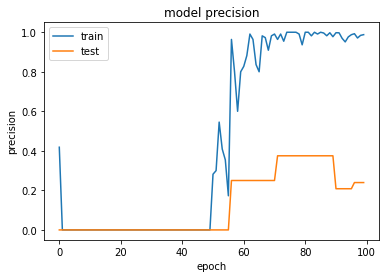

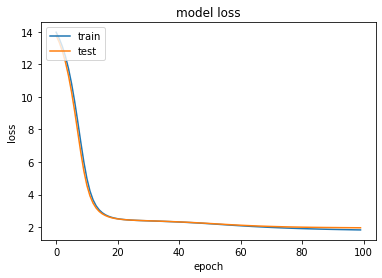

tp: 207, nb_pos: 500
fp: 14, nb_pos: 500
fn: 293, nb_neg: 500
precision: 0.9366515837104072, recall: 0.414, f1: 0.5742024965325936
tp: 207, nb_pos: 500
fp: 14, nb_pos: 500
fn: 293, nb_neg: 500
precision: 0.9366515837104072, recall: 0.414, f1: 0.5742024965325936
tp: 207, nb_pos: 500
fp: 14, nb_pos: 500
fn: 293, nb_neg: 500
precision: 0.9366515837104072, recall: 0.414, f1: 0.5742024965325936
tp: 207, nb_pos: 500
fp: 14, nb_pos: 500
fn: 293, nb_neg: 500
precision: 0.9366515837104072, recall: 0.414, f1: 0.5742024965325936


In [15]:
from dataset_utils_2 import compute_max_length, preprocess_dataset, get_classes_weights
import pandas as pd
from sklearn.utils import shuffle
import numpy as np
from time import time
import tensorflow as tf
import tensorflow.keras as keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, TimeDistributed, Dense, Embedding
from keras_metrics import precision, recall, f1_score, binary_precision, binary_f1_score, binary_recall
from keras.callbacks import EarlyStopping, ModelCheckpoint
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator
from nltk.metrics import edit_distance
from keras.utils import plot_model
import matplotlib.pyplot as plt

#lstm vs bilstm 
def create_model(input_length, embedding):
    model = Sequential()
    model.add(Embedding(128, 300, input_length=input_length, weights=[embedding]))
    model.add(Bidirectional(LSTM(20, return_sequences=True)))
    model.add(TimeDistributed(Dense(1, activation='sigmoid')))

    opt = keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)

    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=[binary_precision(), binary_recall(), binary_f1_score()])
    return model

def train(model, train_data, valid_data):
    nb_examples = len(train_data)
    #numpy.concatenate
    x_train = np.array(train_data[3])
    y_train = np.array(train_data[2])
    
    #numpy.concatenate
    x_valid = np.array(valid_data[3])
    y_valid = np.array(valid_data[2])

    es = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=1, mode='min')
    cp = ModelCheckpoint("modelLSTM.h5", save_best_only=True, monitor='val_loss', mode='min')

    neg_weight = 40

    valid_weights = np.array([neg_weight if y == 0 else 1 for y in y_valid])

    history = model.fit(x=x_train,
              y=y_train,
              epochs=100,
              batch_size=64,
              validation_data=(x_valid, y_valid, valid_weights),
              shuffle=True,
              class_weight={0: neg_weight, 1: 1},
              callbacks=[es, cp]
              )
    
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['precision'])
    plt.plot(history.history['val_precision'])
    plt.title('model precision')
    plt.ylabel('precision')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def test_model(model, test_datasets, distances=None):
    for i, ds in enumerate(test_datasets):
        x_test = np.array(test_data[3])
        y_test = np.array(test_data[2])

        preds = model.predict_on_batch(x_test)
        preds = [1 if preds[i][0] > 0.1 else 0 for i in range(preds.shape[0])]
        tp_ = tp(preds, y_test)
        fp_ = fp(preds, y_test)
        fn_ = fn(preds, y_test)
        p = precision(tp_, fp_)
        r = recall(tp_, fn_)
        f1 = f1_score(p, r)

        print(f"tp: {tp_}, nb_pos: {len([1 for y in y_test if y == 1])}")
        print(f"fp: {fp_}, nb_pos: {len([1 for y in y_test if y == 1])}")
        print(f"fn: {fn_}, nb_neg: {len([1 for y in y_test if y == 0])}")
        print(f"precision: {p}, recall: {r}, f1: {f1}")
    
        if distances:
            thresh = 1
            preds = [preds[j] if distances[i][j] < thresh else 0 for j in range(len(preds))]
            tp_ = tp(preds, y_test)
            fp_ = fp(preds, y_test)
            fn_ = fn(preds, y_test)
            p = precision(tp_, fp_)
            r = recall(tp_, fn_)
            f1 = f1_score(p, r)

            print(f"tp: {tp_}, nb_pos: {len([1 for y in y_test if y == 1])}")
            print(f"fp: {fp_}, nb_pos: {len([1 for y in y_test if y == 1])}")
            print(f"fn: {fn_}, nb_neg: {len([1 for y in y_test if y == 0])}")
            print(f"better: precision: {p}, recall: {r}, f1: {f1}")
            
def tp(preds, targets):
    tp = len([1 for i in range(len(preds)) if preds[i] == 1 and targets[i] == 1])
    
    return tp

def fp(preds, targets):
    fp = len([1 for i in range(len(preds)) if preds[i] == 1 and targets[i] == 0])
    
    return fp

def tn(preds, targets):
    tn = len([1 for i in range(len(preds)) if preds[i] == 0 and targets[i] == 0])

def fn(preds, targets):
    fn = len([1 for i in range(len(preds)) if preds[i] == 0 and targets[i] == 1])
    return fn
    
def precision(tp_, fp_):    
    return tp_ / (tp_ + fp_)

def recall(tp_, fn_):
    return tp_ / (tp_ + fn_)

def f1_score(p, r):
    return 2 * p * r / (p + r)

if __name__ == '__main__':
  
  load = True
  
  print("Loading training and validation dataset...")   

  model = create_model(len_seq, m_embedding)
  train(model, train_data, valid_data)
  test_model(model, test_data)
  model.save("model_test_full_LSTM.h5")